# Tarea 3 - Máquinas de Aprendizaje
## Métodos No-Lineales
### Integrantes: Gabriel Jara, Daniel San Martín

## 1. Small Circle inside Large Circle

El objetivo de esta sección es experimentar con algunos modelos no-lineales sobre un problema de juguete
generado para visualizar algoritmos de *clustering*. Se trata de un problema de clasificación a todas luces
linealmente inseparable, en el sentido que, si denotamos por $\textbf{x}\in\mathbb{R}^2$ un patrón de entrada y por $y\in\{0, 1\}$ su correspondiente etiqueta, no existen $\textbf{w}\in\mathbb{R}^2$ , $b\in\mathbb{R}$ tal que $y(\textbf{w}^T\textbf{x} + b) \geq \rho > 0$. El problema nos permite
hacer un recorrido rápido por las grandes ideas en la búsqueda de la no-linealidad.

<img src="img/1.png">
<center>Figura 1: Distribución deseada para la actividad 1. Los 2 colores representan 2 clases distintas.</center>

(a) Escriba una función que genere (aleatoriamente) $n$ datos etiquetados de la forma $\{(\textbf{x}_1, y_1), ..., (\textbf{x}_n, y_n)\}$, $\textbf{x}_i \in \mathbb{R}^2, ~ y_i \in \{0, 1\}$, con una distribución de probabilidad que refleje la configuración linealmente inseparable que muestra la Fig. 1$^3$. Utilice esta función para crear $1000$ datos de entrenamiento y $1000$ datos de pruebas. Para medir la tendencia de los modelos a sobre-ajuste, agregue un $5\%$ de ruido al dataset, generando $\textbf{x}$’s cercanos a la frontera. Genere un gráfico que muestre datos de entrenamiento y pruebas, identificando cada clase con un color diferente (como lo muestra la Fig. 1).

$^3$Puede generar datos aleatorios distribuidos de manera circular para luego etiquetar aquellos ubicados en el cı́rculo interior como $1$ y en el cı́rculo exterior $0$.

In [ ]:
import numpy as np
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

def do_circles(n=2000, noisy_n=0.05):
    generator = check_random_state(10)
    
    # Creacion de circulos
    linspace = np.linspace(0, 2 * np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)
    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    
    # Creacion de Dataset artificial
    X = np.vstack((np.append(outer_circ_x, inner_circ_x), np.append(outer_circ_y, inner_circ_y))).T
    y = np.hstack([np.zeros(n // 2, dtype=np.intp), np.ones(n // 2, dtype=np.intp)]) # Etiquetas
    X += generator.normal(scale=noisy_n, size=X.shape) # Se agrega ruido
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42) # Split data
    
    return X_train, y_train, X_test, y_test

Para lo que sigue de la actividad utilice la siguiente función para graficar las fronteras de clasificación
en base a la probabilidad que asigna cada algoritmo a la clase de un ejemplo.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_classifier(clf, X_train, Y_train, X_test, Y_test, model_type):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(12, 8))
    axis.scatter(X_train[:,0], X_train[:,1], s=30, c=Y_train, zorder=10, cmap='cool')
    axis.scatter(X_test[:,0], X_test[:,1], s=20, c=Y_test, zorder=10, cmap='Greys')
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    
    # Se diferencia la clasificacion segun si es arbol o rna
    if model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else: raise ValueError('model type not supported')        
        
    Z = Z.reshape(XX.shape)
    Zplot = Z > 0.5
    axis.pcolormesh(XX, YY, Zplot ,cmap='YlGn')
    axis.contour(XX, YY, Z, alpha=1, colors=["k", "k", "k"], linestyles=["--", "-", "--"], levels=[-2, 0, 2])
    plt.show()

(b) Demuestre <u>experimentalmente</u> que una red neuronal artificial correspondiente a $1$ sola neurona (i.e. sin capas escondidas) no puede resolver satisfactoriamente el problema. Puede utilizar la función de activación y el método de entrenamiento que prefiera. Sea convincente: por ejemplo, intente modificar los parámetros de la máquina de aprendizaje, reportando métricas que permitan evaluar el desempeño
del modelo en el problema con cada cambio efectuado. Adapte también la función ```plot_classifier``` para que represente gráficamente la solución encontrada por la red neuronal. Describa y explique lo que observa, reportando gráficos de la solución sólo para algunos casos representativos.

In [ ]:
# Funcion utilizada para graficar y evaluar experimentos
def plotExperiment(lr, hists, scores):
    plt.figure(figsize=(16, 4))
    for i in range(len(lr)):
        plt.plot(hists[i].epoch, hists[i].history['loss'], label=lr[i]) # Plot para cada lr
        test_acc = scores[i][1] # Evaluacion
        print "Learning Rate: %.4f, Testing Accuracy: %.4f" % (lr[i], test_acc)
    plt.title("Training Loss vs epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)     
    plt.show()

In [ ]:
def plotExperiment1(lr, train_e, test_e):
    plt.figure(figsize=(16, 4))
    plt.plot(lr, train_e, label="Train") # Train error
    plt.plot(lr, test_e, label="Test") # Train error
    plt.title("Error vs Learning rate")
    plt.xlabel("Learning rate")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)     
    plt.show()

In [ ]:
# Bibliotecas
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [ ]:
# Generar data
X_train, Y_train, X_test, Y_test = do_circles()

In [ ]:
# Se prueban 5 learning rates distintos
N = 5
lrate = np.linspace(0, 1, N)
models = [None] * N
hists = [None] * N
scores = [None] * N
train_scores = np.zeros(N)
test_scores = np.zeros(N)
n_h = 1

for i in range(N):
    models[i] = Sequential()
    models[i].add(Dense(1, input_dim=X_train.shape[1], 
                       kernel_initializer='uniform', activation='relu')) # Input layer
    models[i].add(Dense(n_h, activation='sigmoid', kernel_initializer='uniform')) # Output layer
    models[i].compile(optimizer=SGD(lr=lrate[i]), loss='binary_crossentropy', metrics=['accuracy'])
    hists[i] =  models[i].fit(X_train, Y_train, epochs=50, batch_size=100, verbose=0)
    scores[i] = models[i].evaluate(X_test, Y_test)
    train_scores[i] = 1 - models[i].evaluate(X_train, Y_train)[1]
    test_scores[i] = 1 - scores[i][1]

In [ ]:
plotExperiment(lrate, hists, scores)

In [ ]:
plotExperiment1(lrate, train_scores, test_scores)

In [ ]:
plot_classifier(models[-1], X_train, Y_train, X_test, Y_test, 'ann')

La Red neuronal de un único nodo no ha logrado generar una frontera que separe efectvamente ambas clases. Se observa que la función de pérdida, en este caso Entropia Cruzada Binaria, alcanza un mínimo de entrenamiento por sobre 0.56. La Exactitud (Accuracy) de clasificación sobre el set de testeo es de casi 0.7, o sea un 70% de las observaciones logra ser bien clasificadas. 

Se repite el experimento utizando Mínimos Cuadrados como función de pérdida, para comprobar si mejora el anterior resultado. 

In [ ]:
# Se prueban 5 learning rates distintos
N = 5
lrate = np.linspace(0, 1, N)
models = [None] * N
hists = [None] * N
scores = [None] * N
train_scores = np.zeros(N)
test_scores = np.zeros(N)
n_h = 1

for i in range(N):
    models[i] = Sequential()
    models[i].add(Dense(1, input_dim=X_train.shape[1], 
                       kernel_initializer='uniform', activation='relu')) # Input layer
    models[i].add(Dense(n_h, activation='sigmoid', kernel_initializer='uniform')) # Output layer
    models[i].compile(optimizer=SGD(lr=lrate[i]), loss='mean_squared_error', metrics=['accuracy'])
    hists[i] =  models[i].fit(X_train, Y_train, epochs=50, batch_size=100, verbose=0)
    scores[i] = models[i].evaluate(X_test, Y_test)
    train_scores[i] = 1 - models[i].evaluate(X_train, Y_train)[1]
    test_scores[i] = 1 - scores[i][1]

In [ ]:
plotExperiment(lrate, hists, scores)

In [ ]:
plotExperiment1(lrate, train_scores, test_scores)

In [ ]:
plot_classifier(models[-1], X_train, Y_train, X_test, Y_test, 'ann')

Mínimos Cuadrados no mejora significativamente el resultado anterior. La función de perdida disminuye su valor, pero no es comparable dado que es una métrica diferente. La efectividad del clasificador sobre el set de testeo es similar a la anterior. Se observa que el problema del clasificador no está en la función de pérdida, sino en su limitada arquitectura que sólo le permite trazar fronteras de clasificación lineales, siendo el problema no linealmente separable.  

(c) Demuestre <u>experimentalmente</u> que una red neuronal artificial con $1$ capa escondida puede resolver satisfactoriamente el problema obtenido en (a). Puede utilizar la arquitectura y el método de entrenamiento que prefiera, pero en esta actividad puede optar tranquilamente por usar los hiper-parámetros que se entregan como referencia en el código de ejemplo. Cambie el número de neuronas $N_h$ en la red entre $2$ y $32$ en potencias de $2$, graficando el error de entrenamiento y pruebas como función de $N_h$. Describa y explique lo que observa. Utilice la función plot classifier, diseñada anteriormente, para construir gráficos de la solución en algunos casos representativos.

In [ ]:
def plotExperiment2(Nh, train_e, test_e):
    plt.figure(figsize=(16, 4))
    plt.plot(Nh, train_e, label="Train") # Train error
    plt.plot(Nh, test_e, label="Test") # Train error
    plt.title("Error vs " + r"$N_h$")
    plt.xlabel(r"$N_h$")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)     
    plt.show()

In [ ]:
N = 5
n_h = [2**i for i in range(1, N+1)]
models = [None] * N
#hists = [None] * N
#scores = [None] * N
train_scores = np.zeros(N)
test_scores = np.zeros(N)

In [ ]:
for i in range(N):
    models[i] = Sequential()
    models[i].add(Dense(n_h[i], input_dim=X_train.shape[1], 
                       kernel_initializer='uniform', activation='relu')) # Input layer
    models[i].add(Dense(1, activation='sigmoid', kernel_initializer='uniform')) # Output layer
    models[i].compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
    hist =  models[i].fit(X_train, Y_train, epochs=50, batch_size=100, verbose=0)
    train_scores[i] = 1 - hist.history['acc'][-1] # Ultimo error de training
    scores = models[i].evaluate(X_test, Y_test)
    test_scores[i] = 1 - scores[1]
    print " Nh: %d, Testing Accuracy: %.4f" % (n_h[i], scores[1])

In [ ]:
plotExperiment2(n_h, train_scores, test_scores)

In [ ]:
plot_classifier(models[0], X_train, Y_train, X_test, Y_test, 'ann')

Se aprecia una mejora significativa respecto a la situación anterior, puesto que la efectividad del modelo se incrementa a sobre 0.85. La gráfica de la frontera de clasificación permite apreciar que al incorporar un nodo adicional la frontera puede representar una clasificación lineal en dos tramos, lo que explica la mejora. 

In [ ]:
plot_classifier(models[1], X_train, Y_train, X_test, Y_test, 'ann')

Se constata que con cuatro nodos en la capa oculta, la Red Neuronal logra efectivamente generar una frontera de clasificación que separa ambas clases. En consecuencia, la función de perdida logra decaer a cero, y la efectividad del predictor sobre la muestra de testeo llega a uno, denotando que todas las observaciones fueron bien clasificadas. 

Seguir aumentando los nodos en la capa oculta permitirá suavizar la frontera de clasificación, pero ya no podrá mejorar la clasificación, puesto que ya es 100% correcta. 

In [ ]:
plot_classifier(models[-1], X_train, Y_train, X_test, Y_test, 'ann')

(d) Demuestre <u>experimentalmente</u> que stump (árbol de clasificación de $1$ nivel) no puede resolver satisfactoriamente el problema anterior. Puede utilizar el criterio y la función de partición que prefiera. Sea
convincente: por ejemplo, intente modificar los parámetros de la máquina, reportando métricas que permitan evaluar el desempeño del modelo en el problema con cada cambio efectuado. Adapte también la función ```plot_classifier``` para que represente gráficamente la solución encontrada por el árbol. Describa y explique lo que observa, reportando gráficos de la solución sólo para algunos casos representativos.

In [ ]:
from sklearn.tree import DecisionTreeClassifier as Tree

clf=Tree(criterion='gini', splitter='best', random_state=0, max_depth=1)
clf.fit(X_train,Y_train)
acc_test = clf.score(X_test,Y_test)
print "Test Accuracy = %f"%acc_test
print clf.tree_.max_depth
plot_classifier(clf,X_train,Y_train,X_test,Y_test,'tree')

Se aprecia que un árbol con sólo un nivel de profundidad no puede establecer una frontera de clasificación efectiva en este caso. El clasificador es incluso más limitado que la Red Neuronal con un nodo, al quedar limitado a trazados ortogonales a una de las dimensiones de las variables independientes. 

Se prueba a continuación cambiar el criterio de clasificación, originalmete coeficiente de Gino, para probar con entropía y confirmar si esto permite mejorar los resultados. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier as Tree

clf=Tree(criterion='entropy', splitter='best', random_state=0, max_depth=1)
clf.fit(X_train,Y_train)
acc_test = clf.score(X_test,Y_test)
print "Test Accuracy = %f"%acc_test
print clf.tree_.max_depth
plot_classifier(clf,X_train,Y_train,X_test,Y_test,'tree')

Como era predecible, el resultado no mejora con el cambio de criterio. Nuevamente, el problema está en la limitada arquitectura del modelo, que no permite resolver un problema no linealmente separable. 

(e) Demuestre experimentalmente que un árbol de clasificación de múltiples niveles puede resolver satisfactoriamente el problema estudiado. Puede utilizar el criterio y la función de partición que prefiera, pero puede optar tranquilamente por usar los hiper-parámetros que se entregan como referencia en el código de ejemplo. Cambie el número de niveles admitidos en el árbol $N_t$ entre $2$ y $20$, graficando el error de entrenamiento y pruebas como función de $N_t$. Describa y explique lo que observa. Utilice la función ```plot_classifier```, diseñada anteriormente, para construir gráficos de la solución en algunos casos representativos.

In [ ]:
def plotExperiment3(Nt, train_e, test_e):
    plt.figure(figsize=(16, 4))
    plt.plot(Nt, train_e, label="Train") # Train error
    plt.plot(Nt, test_e, label="Test") # Train error
    plt.title("Error vs " + r"$N_t$")
    plt.xlabel(r"$N_t$")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)     
    plt.show()

In [ ]:
n_t = np.arange(2, 21)
N = len(n_t)
clfs = [None] * N
#hists = [None] * N
#scores = [None] * N
train_scores = np.zeros(N)
test_scores = np.zeros(N)

In [ ]:
for i in range(N):
    print(n_t[i])
    clfs[i] = Tree(criterion='gini', splitter='best', random_state=0, max_depth=n_t[i])
    clfs[i].fit(X_train, Y_train)
    train_scores[i] = 1 - clfs[i].score(X_train, Y_train)
    acc_test = clfs[i].score(X_test, Y_test)
    test_scores[i] = 1 - acc_test
    print "Test Accuracy = %f " % acc_test
    #print clf.tree_.max_depth
    #plot_classifier(clf,X_train,Y_train,X_test,Y_test,'tree')
    #models[i] = Sequential()
    #models[i].add(Dense(1, input_dim=X_train.shape[1], 
    #                   kernel_initializer='uniform', activation='relu')) # Input layer
    #models[i].add(Dense(n_h, activation='sigmoid', kernel_initializer='uniform')) # Output layer
    #models[i].compile(optimizer=SGD(lr=lrate[i]), loss='mean_squared_error', metrics=['accuracy'])
    #hists[i] =  models[i].fit(X_train, Y_train, epochs=50, batch_size=100, verbose=0)
    #scores[i] = models[i].evaluate(X_test, Y_test)

In [ ]:
plotExperiment3(n_t, train_scores, test_scores)

In [ ]:
plot_classifier(clfs[0], X_train, Y_train, X_test,Y_test, 'tree')

Al configurar el árbol con dos niveles, inmediatamente se percibe una mejora significativa, gracias a que ahora puede establecer una fronteras de clasificación con dos secciones, las que tendrán que ser paralelos u ortogonales. En este caso se aprecia de a gráfica que resultaron paralelas. 

In [ ]:
plot_classifier(clfs[1], X_train, Y_train, X_test,Y_test, 'tree')

Un tercer nivel permitió que una nueva mejora, ahora la frontera tiene tres segmentos. 

In [ ]:
plot_classifier(clfs[2], X_train, Y_train, X_test,Y_test, 'tree')

Con cuatro niveles se logra una fronetera de clasificación adecuada a la naturaleza del problema, alcanzando en este caso una efectividad en la clasificación del set de testeo de 0.994. 

In [ ]:
plot_classifier(clfs[4], X_train, Y_train, X_test,Y_test, 'tree')

Agregar un quinto nivel no mejoró la clasificación, puesto que si bien el árbol mejora algo en el set de entrenamiento, empeora su efectividad en el set de testeo, lo que evidencia sobreajuste. 

In [ ]:
plot_classifier(clfs[5], X_train, Y_train, X_test,Y_test, 'tree')

De 5 niveles en adelante el árbol resultante ya no varía, puesto que los niveles adicionales no permiten mejorar la clasificación durante el entrenamiento. 

In [ ]:
plot_classifier(clfs[-1], X_train, Y_train, X_test,Y_test, 'tree')

Se probará a continuación nuevamente el modelo de árbol con 4 niveles, pero esta vez con entropia como criterio de clasificación, para ver si se mejora los resultados anteriores. 

In [ ]:
clf = Tree(criterion='entropy', splitter='best', random_state=0, max_depth=4)
clf.fit(X_train,Y_train)
acc_test = clf.score(X_test,Y_test)
print "Test Accuracy = %f"%acc_test
print clf.tree_.max_depth
plot_classifier(clf, X_train, Y_train, X_test, Y_test, 'tree')

En este caso el clasificador resultante con entropía fue levemente mejor que el obtenido con gini, de acuerdo a la precisión con que clasificó el set de testeo. 

(f) Como ya se demostró experimentalmente que este problema es linealmente inseperable, ahora se pide experimentar otra alternativa. Para ello deberá realizar una proyección de los datos a un nuevo espacio dimensional (manifold) en el cual se reconozcan sus patrones no lineales, para poder trabajarlos con fronteras lineales. Utilice la técnica de PCA con la ayuda de un Kernel Gaussiano ([2]) para extraer sus vectores con dimensión infinita de mayor varianza.

In [ ]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel="rbf", gamma=5)
kpca = kpca.fit(X_train)
Xkpca_train = kpca.transform(X_train)
Xkpca_test = kpca.transform(X_test)

(g) Ajuste un algoritmo de aprendizaje con fronteras lineal para los datos proyectados en este nuevo espacio que captura sus componentes no lineales, muestre graficamente que el problema ahora puede ser resulto con estos métodos. Reporte métricas para evaluar el desempeño, comente y concluya.

In [ ]:
clf = Tree(criterion='gini', splitter='best', random_state=42, max_depth=1)
clf.fit(Xkpca_train, Y_train)
acc_test = clf.score(Xkpca_test, Y_test)
print "Test Accuracy = %f"%acc_test
print clf.tree_.max_depth
plot_classifier(clf, Xkpca_train, Y_train, Xkpca_test,Y_test,'tree')

Luego de realizada la descomposición con Kernel PCA, el problema pasa a ser linealmente separable. Utilizando un árbol de decisión con un nivel de profundidad, se pudo sin problema generar un clasificador que presenta 100% de éxito en la clasificación sobre el set de testeo. 

## 2. Bike Sharing: Predicción de Demanda Horaria

En esta sección simularemos nuestra participación en el desafı́o Bike Sharing Demand de Kaggle [3]. El objetivo es predecir la demanda de bicicletas sobre la red Capital Bikeshare de la ciudad de Washington, D.C., en función de la hora del dı́a y otras variables descritas en la tabla 1. En principio, y como muestra la figura, la función es altamente no lineal y no determinista como función de la hora del dı́a. Su objetivo será entrenar un modelo para obtener un puntaje correspondiente al top-100 del "leaderboard" final, es decir superior o igual a $0.37748$. La función utilizada para evaluar este concurso Kaggle se proporciona en la siguiente ecuación:

\begin{equation}
    E_{bikes}(\textbf{y},\hat{\textbf{y}}) = \frac1n \sum_i (\ln(y_i + 1) - \ln(\hat{y}_i + 1))^2,
\end{equation}

donde $\textbf{y},\hat{\textbf{y}} \in \mathbb{R}^n$ denotan los vectores de observaciones y predicciones respectivamente. Como el dataset de pruebas original no está disponible se fabricará uno, correspondiente al $20\%$ de los datos de entrenamiento. Además, se pondrá a su disposición un subconjunto independiente de datos con propósitos de validación. Usted podrá descargar los archivos correspondientes al subconjunto de entrenamiento y pruebas a utilizar ejecutando los siguientes comandos:

```wget http://octopus.inf.utfsm.cl/~ricky/bike_sharing_train.csv```

```wget http://octopus.inf.utfsm.cl/~ricky/bike_sharing_val.csv```

```wget http://octopus.inf.utfsm.cl/~ricky/bike_sharing_test.csv```

<img src="img/2.png">
<center>Tabla 1: Atributos para el Problema 2 (*Bike Sharing*).</center>

(a) Cargue los datos de entrenamiento y pruebas como dataframes de *pandas*. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distintos y, si corresponde, un gráfico (e.g. un histograma) que resuma su comportamiento. Su primera operación de pre-procesamiento de datos será obtener la hora del dı́a desde el campo fecha (que en este momento es de tipo string), creando una nueva columna denominada *hour* y de tipo *int*. Para hacer esta operación se concatenarán los dataframes de entrenamiento y pruebas y luego se volverán a separar manteniendo la separación original.

In [119]:
import pandas as pd
import numpy as np

# Cargar datos 
dftrain = pd.read_csv('data/bike_sharing_train.csv')
dfval = pd.read_csv('data/bike_sharing_val.csv')
dftest = pd.read_csv('data/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain, dfval, dftest])

df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])

In [120]:
print '\nSummary - dataframe completo:\n'
df.iloc[:,1:-1].describe()


Summary - dataframe completo:



,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


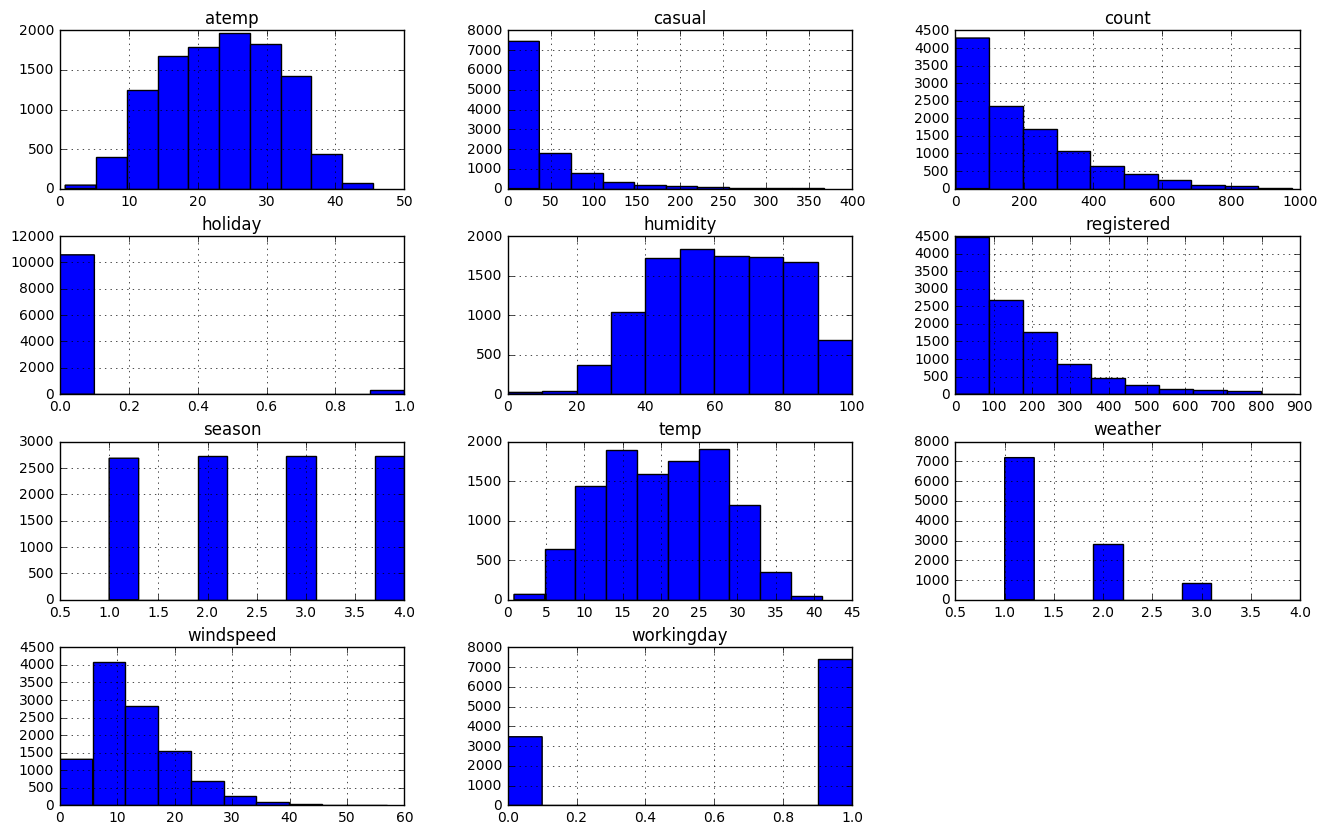

In [121]:
import matplotlib.pyplot as plt

df.iloc[:,1:-1].hist(figsize=(16, 10))
plt.show()

(b) Entrene un árbol de regresión para resolver el problema usando parámetros por defecto. Con este
fin, construya una matriz $\textbf{X}_{train}$ de forma $n_{train} \times d_1$ que contenga los datos de entrenamiento en sus filas, seleccionando las columnas que desee/pueda utilizar para el entrenamiento. Implemente además, la función de evaluación que hemos definido anteriormente para este problema. Evalúe el árbol de regresión ajustado a los datos de entrenamiento sobre el conjunto de entrenamiento y pruebas. Construya un gráfico que compare las predicciones con los valores reales. En este punto usted debiese tener un modelo con puntaje del orden de $0.59$, lo que lo dejará más o menos en la posición $2140$ de la competencia.

In [122]:
from sklearn.tree import DecisionTreeRegressor as Tree
import matplotlib.pyplot as plt

def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

SCORE TEST=0.703388
KAGG EVAL TRAIN =0.028516
KAGG EVAL VALIDATION =0.554511
KAGG EVAL TEST =0.574239
Max Depth: 28


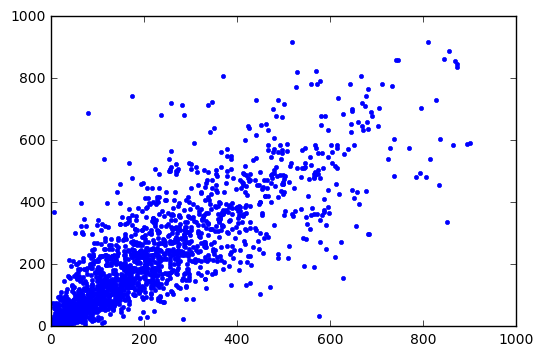

In [123]:
# Select columns 
Xdf = df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']]
Ydf = df.ix[:,'count']

# Split dataset 
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

# Model training
model = Tree(random_state=0)
model.fit(X_train, Y_train)
score_test = model.score(X_test,Y_test)
print "SCORE TEST=%f"%score_test

# Predict model - score 
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train, Y_train)
kagg_val = eval_bikemodel(Y_pred_val, Y_val)
kagg_test = eval_bikemodel(Y_pred_test, Y_test)
print "KAGG EVAL TRAIN =%f"%kagg_train
print "KAGG EVAL VALIDATION =%f"%kagg_val
print "KAGG EVAL TEST =%f"%kagg_test
print "Max Depth: "+ str(model.tree_.max_depth)

# Plot
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

Luego de entrenado el Árbol de Clasificación básico, se aprecia que en la muestra de testeo la evaluación alcanza error de 0.574. El árbol de alcanza este valor fue de 28 niveles de profundidad. 

(c) Mejore el árbol de regresión definido en el punto anterior haciendo modificaciones a los hiper-parámetros del modelo. Por ejemplo, como estos modelos tienden a sobre-ajustar, podrı́a intentar limitar la profundidad del árbol (¿Por qué esto debiese ayudar?). Naturalmente, está absolutamente prohibido tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento. Con estas modificaciones debiese poder mejorar su ranking en unas $300$ posiciones.

Al "podar" el árbol, estamos evitando darle mayor poder de aprendizaje al árbol lo que permite que este no sobreajuste. Se recurrirá a la muestra de validación para seleccionar el nivel adecuado. 

In [124]:
best_depth = 0
kagg_validated = 1

for d in range(1,29):
    model = Tree(random_state=0, max_depth=d)
    model.fit(X_train, Y_train)
    Y_pred_val = model.predict(X_val)
    kagg_val = eval_bikemodel(Y_pred_val, Y_val)
    print "KAGG EVAL VAL =%f"%kagg_val
    print "Max Depth: "+ str(model.tree_.max_depth)
    print ''
    if kagg_val < kagg_validated:
        best_depth = d
        kagg_validated = kagg_val
print ''
print 'BEST TREE MODEL:'
print "KAGG EVAL VAL =%f"%kagg_validated
print "Max Depth: "+ str(best_depth)

# Testing score
model = Tree(random_state=0, max_depth=best_depth)
model.fit(X_train, Y_train)
Y_pred_test = model.predict(X_test)
our_val = eval_bikemodel(Y_pred_test, Y_test)
print ""
print "OUR TEST EVAL =%f"%our_val

KAGG EVAL VAL =0.979204
Max Depth: 1

KAGG EVAL VAL =0.896665
Max Depth: 2

KAGG EVAL VAL =0.801210
Max Depth: 3

KAGG EVAL VAL =0.728483
Max Depth: 4

KAGG EVAL VAL =0.631234
Max Depth: 5

KAGG EVAL VAL =0.572753
Max Depth: 6

KAGG EVAL VAL =0.550529
Max Depth: 7

KAGG EVAL VAL =0.486956
Max Depth: 8

KAGG EVAL VAL =0.480482
Max Depth: 9

KAGG EVAL VAL =0.476274
Max Depth: 10

KAGG EVAL VAL =0.480193
Max Depth: 11

KAGG EVAL VAL =0.489915
Max Depth: 12

KAGG EVAL VAL =0.503234
Max Depth: 13

KAGG EVAL VAL =0.513617
Max Depth: 14

KAGG EVAL VAL =0.530887
Max Depth: 15

KAGG EVAL VAL =0.535001
Max Depth: 16

KAGG EVAL VAL =0.541478
Max Depth: 17

KAGG EVAL VAL =0.550662
Max Depth: 18

KAGG EVAL VAL =0.552593
Max Depth: 19

KAGG EVAL VAL =0.546219
Max Depth: 20

KAGG EVAL VAL =0.551071
Max Depth: 21

KAGG EVAL VAL =0.553346
Max Depth: 22

KAGG EVAL VAL =0.556618
Max Depth: 23

KAGG EVAL VAL =0.548437
Max Depth: 24

KAGG EVAL VAL =0.553190
Max Depth: 25

KAGG EVAL VAL =0.551141
Max Depth:

La mejor configuración, según validación, es con 10 niveles. Este clasificador logra 0.516 de evaluación sobre la muestra de testeo. 

(d) Mejore el árbol de regresión definido en el punto anterior haciendo modificaciones sobre la representación utilizada para aprender desde los datos. Por ejemplo, los histogramas que construyó en el punto (a) ası́ como la forma especial de la función de evaluación, sugieren una cierta transformación de la variable respuesta. Podrı́a intentar también normalizando los datos o normalizando la respuesta. Otra opción es intentar rescatar algo más acerca de la fecha (anteriormente sólo se extrajo la hora), como por ejemplo el año o el dı́a de la semana (’lunes’,’martes’, etc) que corresponde. Sea creativo, este paso le debiese reportar un salto de calidad muy significativo. Una observación importante es que si hace una transformación a la variable respuesta (por ejemplo raı́z cuadrada), debe invertir esta transformación antes de evaluar el desempeño con ``eval_bikemodel`` (por ejemplo, elevar al cuadrado si tomó raı́z cuadrada). Con modificaciones de este tipo, podrı́a mejorar su ranking en unas $1000$ posiciones, entrando ya al top-$1000$ con un score del orden de $0.45$.

Primero se agrega la información del día y del año.

In [125]:
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek#0:lunes,6:domingo
#df['cday'] = pd.to_numeric(df['cday'])
df['year'] = pd.to_datetime(df['datetime']).dt.year
#df['year'] = pd.to_numeric(df['year'])

Xdf = df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday', 'year']]

#print '\nSummary - dataframe completo:\n'
Xdf.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,cday,year
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,11.541613,3.013963,2011.501929
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,6.915838,2.004585,0.500019
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,2011.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,6.000000,1.000000,2011.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,12.000000,3.000000,2012.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,18.000000,5.000000,2012.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,23.000000,6.000000,2012.000000


In [126]:
# Split data
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

Probamos con la misma estrategia anterior.

In [127]:
best_depth = 0
kagg_validated = 1

for d in range(1,29):
    model = Tree(random_state=0, max_depth=d)
    model.fit(X_train, Y_train)
    Y_pred_val = model.predict(X_val)
    kagg_val = eval_bikemodel(Y_pred_val, Y_val)
    print "KAGG EVAL VAL =%f"%kagg_val
    print "Max Depth: "+ str(model.tree_.max_depth)
    print ''
    if kagg_val < kagg_validated:
        best_depth = d
        kagg_validated = kagg_val
print ''
print 'BEST TREE MODEL:'
print "KAGG EVAL VAL =%f"%kagg_validated
print "Max Depth: "+ str(best_depth)

# Testing score
model = Tree(random_state=0, max_depth=best_depth)
model.fit(X_train, Y_train)
Y_pred_test = model.predict(X_test)
our_val = eval_bikemodel(Y_pred_test, Y_test)
print ""
print "OUR TEST EVAL =%f"%our_val

KAGG EVAL VAL =0.979204
Max Depth: 1

KAGG EVAL VAL =0.903080
Max Depth: 2

KAGG EVAL VAL =0.794052
Max Depth: 3

KAGG EVAL VAL =0.711080
Max Depth: 4

KAGG EVAL VAL =0.602915
Max Depth: 5

KAGG EVAL VAL =0.553608
Max Depth: 6

KAGG EVAL VAL =0.501804
Max Depth: 7

KAGG EVAL VAL =0.464298
Max Depth: 8

KAGG EVAL VAL =0.410504
Max Depth: 9

KAGG EVAL VAL =0.405092
Max Depth: 10

KAGG EVAL VAL =0.394671
Max Depth: 11

KAGG EVAL VAL =0.400415
Max Depth: 12

KAGG EVAL VAL =0.406072
Max Depth: 13

KAGG EVAL VAL =0.411179
Max Depth: 14

KAGG EVAL VAL =0.414860
Max Depth: 15

KAGG EVAL VAL =0.416660
Max Depth: 16

KAGG EVAL VAL =0.423026
Max Depth: 17

KAGG EVAL VAL =0.425225
Max Depth: 18

KAGG EVAL VAL =0.427340
Max Depth: 19

KAGG EVAL VAL =0.424861
Max Depth: 20

KAGG EVAL VAL =0.426174
Max Depth: 21

KAGG EVAL VAL =0.423736
Max Depth: 22

KAGG EVAL VAL =0.423946
Max Depth: 23

KAGG EVAL VAL =0.426938
Max Depth: 24

KAGG EVAL VAL =0.423991
Max Depth: 25

KAGG EVAL VAL =0.425673
Max Depth:

Probamos con una transformacion a los datos.

In [128]:
X_train_ln = np.log(X_train+1)**2
X_val_ln = np.log(X_val+1)**2
X_test_ln = np.log(X_test+1)**2
best_depth = 0
kagg_validated = 1

for d in range(1,29):
    
    model = Tree(random_state=0, max_depth=d)
    model.fit(X_train_ln, Y_train)
    Y_pred_val = model.predict(X_val_ln)
    kagg_val = eval_bikemodel(Y_pred_val, Y_val)
    print "KAGG EVAL VAL =%f"%kagg_val
    print "Max Depth: "+ str(model.tree_.max_depth)
    print ''
    
    if kagg_val < kagg_validated:
        best_depth = d
        kagg_validated = kagg_val
print ''
print 'BEST TREE MODEL:'
print "KAGG EVAL VAL =%f"%kagg_validated
print "Max Depth: "+ str(best_depth)

# Testing score
model = Tree(random_state=0, max_depth=best_depth)
model.fit(X_train_ln, Y_train)
Y_pred_test = model.predict(X_test_ln)
our_val = eval_bikemodel(Y_pred_test, Y_test)
print ""
print "OUR TEST EVAL =%f"%our_val

KAGG EVAL VAL =0.979204
Max Depth: 1

KAGG EVAL VAL =0.903080
Max Depth: 2

KAGG EVAL VAL =0.794052
Max Depth: 3

KAGG EVAL VAL =0.711080
Max Depth: 4

KAGG EVAL VAL =0.602915
Max Depth: 5

KAGG EVAL VAL =0.553608
Max Depth: 6

KAGG EVAL VAL =0.501396
Max Depth: 7

KAGG EVAL VAL =0.462677
Max Depth: 8

KAGG EVAL VAL =0.409891
Max Depth: 9

KAGG EVAL VAL =0.403844
Max Depth: 10

KAGG EVAL VAL =0.393531
Max Depth: 11

KAGG EVAL VAL =0.397293
Max Depth: 12

KAGG EVAL VAL =0.404172
Max Depth: 13

KAGG EVAL VAL =0.410172
Max Depth: 14

KAGG EVAL VAL =0.414668
Max Depth: 15

KAGG EVAL VAL =0.416955
Max Depth: 16

KAGG EVAL VAL =0.419419
Max Depth: 17

KAGG EVAL VAL =0.423211
Max Depth: 18

KAGG EVAL VAL =0.424719
Max Depth: 19

KAGG EVAL VAL =0.423605
Max Depth: 20

KAGG EVAL VAL =0.423476
Max Depth: 21

KAGG EVAL VAL =0.418857
Max Depth: 22

KAGG EVAL VAL =0.420947
Max Depth: 23

KAGG EVAL VAL =0.423117
Max Depth: 24

KAGG EVAL VAL =0.420085
Max Depth: 25

KAGG EVAL VAL =0.422423
Max Depth:

Al incorporar la variable año, y utilizando la transformación de datos $z=log(x+1)²$, se logra reducir el error en el set de validación a 0.393. Sin embargo, en el set de testeo no baja de 0.434. 

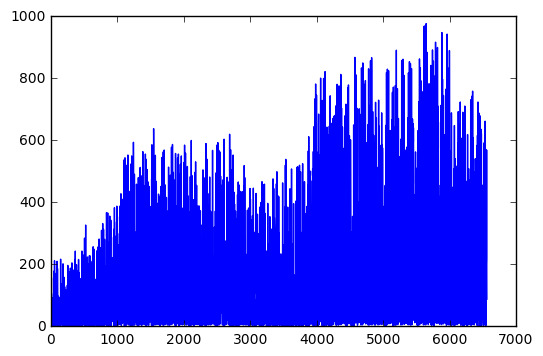

In [129]:
plt.plot(Y_train)
plt.show()

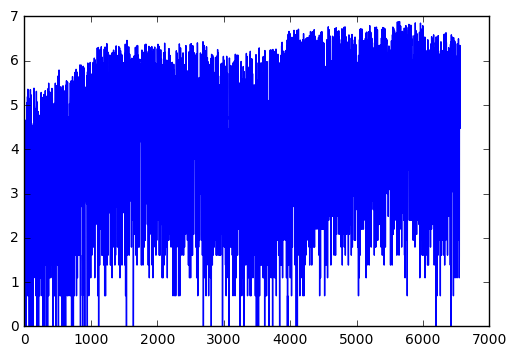

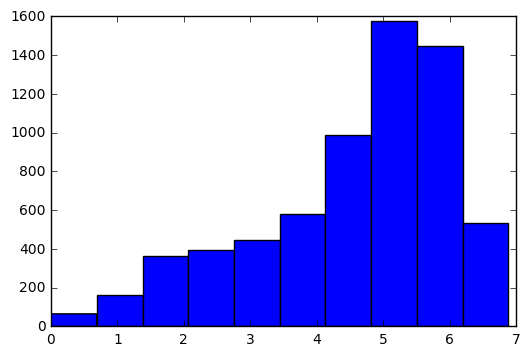

In [130]:
plt.plot(np.log(Y_train))
plt.show()
plt.hist(np.log(Y_train))
plt.show()

(e) Entrene una SVM no lineal para resolver el problema midiendo el efecto de las distintas representaciones
que haya descubierto hasta este punto. Un detalle importante es que antes de entrenar la SVM serı́a
aconsejable hacer dos tipos de pre-procesamiento adicional de los datos: (i) codificar las variables
categóricas en un modo apropiado - por ejemplo como vector binario con un 1 en la posición del
valor adoptado-, (ii) escalar los atributos de modo que queden centrados y con rangos comparables.
Usando parámetros por defecto para la SVM debiese obtener un score del orden de $0.344$, quedando
definitivamente en el top-$10$ de la competencia.

In [188]:
import pandas as pd
import numpy as np

def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

dftrain = pd.read_csv('data/bike_sharing_train.csv')
dfval = pd.read_csv('data/bike_sharing_val.csv')
dftest = pd.read_csv('data/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)

df = pd.concat([dftrain, dfval, dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek
df['hour'] = pd.to_numeric(df['hour'])
df['cday'] = pd.to_numeric(df['cday'])
df['year'] = pd.to_datetime(df['datetime']).dt.year
df['year'] = pd.to_numeric(df['year'])
Xdf = df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity',
             'windspeed','hour','cday']]

Xdf = pd.get_dummies(Xdf, columns=['season', 'weather','hour','cday'])

Ydf = df.ix[:,'count']

#print '\nSummary - Xdataframe dummies:\n'
Xdf.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,...,hour_21,hour_22,hour_23,cday_0,cday_1,cday_2,cday_3,cday_4,cday_5,cday_6
count,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,20.23086,23.655084,61.886460,12.799395,0.246739,0.251056,0.251056,0.251148,...,0.041889,0.041889,0.041889,0.142477,0.141374,0.142477,0.142660,0.140456,0.145508,0.145049
std,0.166599,0.466159,7.79159,8.474601,19.245033,8.164537,0.431133,0.433641,0.433641,0.433694,...,0.200344,0.200344,0.200344,0.349554,0.348423,0.349554,0.349742,0.347475,0.352628,0.352166
min,0.000000,0.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,13.94000,16.665000,47.000000,7.001500,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,20.50000,24.240000,62.000000,12.998000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,26.24000,31.060000,77.000000,16.997900,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,41.00000,45.455000,100.000000,56.996900,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [189]:
# Split data
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

In [190]:
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.transform(X_test)

Y_train = np.log(Y_train)
#Y_val = np.log(Y_val)
#Y_test = np.log(Y_test)

In [191]:
from sklearn.svm import SVR

model = SVR()
model.fit(X_train, Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
#kagg_val = eval_bikemodel(Y_pred_val, Y_val)
kagg_val = eval_bikemodel(np.exp(Y_pred_val)-1, Y_val)
print "KAGG EVAL VAL =%f"%kagg_val
print ''
#print eval_bikemodel(np.exp(Y_pred_test), Y_test)

KAGG EVAL VAL =0.408298



Con SVR, descomponiendo las variables categóricas como variables dummies e incorporando la trasformación $log(y+1)$ para suavizar la variable objetivo, se logra un error de evaluación de 0.4083. 

(f) Mejore la SVM definida en el punto anterior haciendo modificaciones a los hiper-parámetros de la máquina ($C$, $\epsilon$ o la misma función de kernel). Naturalmente, está absolutamente prohibido tomar este tipo de decisiones de diseño mirando el resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento.

In [192]:
model = SVR(kernel='sigmoid', C=1,epsilon=0.1)

model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

KAGG EVAL VAL =nan


In [193]:
C_range = np.logspace(-2,2,3)#10. ** np.arange(-5, 3)
epsilon_range = np.logspace(-2,2,3) #10. ** np.arange(-8, 1)

best_C = "none"
best_epsilon = "none"
kagg_validated = 2

for c in C_range:
    for e in epsilon_range:
        model = SVR(C=c,epsilon=e)
        model.fit(X_train,Y_train)
        Y_pred_val = model.predict(X_val)
        kagg_val = eval_bikemodel(np.exp(Y_pred_val)-1, Y_val)
        print "C = " +str(c)+ " epsilon = " + str(e)
        print "KAGG EVAL VAL =%f"%kagg_val
        print ""
        if kagg_val < kagg_validated:
            best_C = c
            best_epsilon = e
            kagg_validated = kagg_val

print ""
print "Best C = " +str(best_C)+ " Best epsilon = " + str(best_epsilon)
print "KAGG EVAL VAL =%f"%kagg_validated

C = 0.01 epsilon = 0.01
KAGG EVAL VAL =0.969912

C = 0.01 epsilon = 1.0
KAGG EVAL VAL =1.075590

C = 0.01 epsilon = 100.0
KAGG EVAL VAL =1.869561

C = 1.0 epsilon = 0.01
KAGG EVAL VAL =0.414763

C = 1.0 epsilon = 1.0
KAGG EVAL VAL =0.589646

C = 1.0 epsilon = 100.0
KAGG EVAL VAL =1.869561

C = 100.0 epsilon = 0.01
KAGG EVAL VAL =0.536696

C = 100.0 epsilon = 1.0
KAGG EVAL VAL =0.577963

C = 100.0 epsilon = 100.0
KAGG EVAL VAL =1.869561


Best C = 1.0 Best epsilon = 0.01
KAGG EVAL VAL =0.414763


Los parametos que se probaron no consigen mejor resultado que los por defecto. 

(g) Evalúe el efecto de utilizar el dataset de validación para entrenamiento y seleccionar los parámetros estructurales del árbol de clasificación y la SVM usando validación cruzada. El código de ejemplo para esto ha sido proporcionado en las tareas $1$ y $2$, pero se adjunta de nuevo a continuación

In [27]:
# Para arboles
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
Xm = X_train
ym = Y_train

for d in range(1, 29):
    mse_cv = 0    
    for train, val in kf.split(Xm):        
        model = Tree(random_state=0, max_depth=d)
        model.fit(Xm[train], ym[train])
        yhat_val = model.predict(Xm[val])
        ytrue_val = ym[val]
        score_fold = eval_bikemodel(np.exp(yhat_val)-1, ytrue_val)
        mse_cv += score_fold
    mse_cv = mse_cv / 10
    print "d: %d, KAGG EVAL CV: %.4f" % (d, mse_cv)

d: 1, KAGG EVAL CV: 2.9399
d: 2, KAGG EVAL CV: 2.9688
d: 3, KAGG EVAL CV: 2.9917
d: 4, KAGG EVAL CV: 3.0171
d: 5, KAGG EVAL CV: 3.0006
d: 6, KAGG EVAL CV: 3.0636
d: 7, KAGG EVAL CV: 3.0727
d: 8, KAGG EVAL CV: 3.0882
d: 9, KAGG EVAL CV: 3.0856
d: 10, KAGG EVAL CV: 3.0952
d: 11, KAGG EVAL CV: 3.0815
d: 12, KAGG EVAL CV: 3.0707
d: 13, KAGG EVAL CV: 3.0895
d: 14, KAGG EVAL CV: 3.0867
d: 15, KAGG EVAL CV: 3.0904
d: 16, KAGG EVAL CV: 3.0934
d: 17, KAGG EVAL CV: 3.0982
d: 18, KAGG EVAL CV: 3.0976
d: 19, KAGG EVAL CV: 3.1003
d: 20, KAGG EVAL CV: 3.1032
d: 21, KAGG EVAL CV: 3.1075
d: 22, KAGG EVAL CV: 3.1064
d: 23, KAGG EVAL CV: 3.1095
d: 24, KAGG EVAL CV: 3.1085
d: 25, KAGG EVAL CV: 3.1097
d: 26, KAGG EVAL CV: 3.1098
d: 27, KAGG EVAL CV: 3.1144
d: 28, KAGG EVAL CV: 3.1121


In [26]:
# Para SVM
from sklearn.model_selection import KFold

C_range = np.logspace(-2,2,3)
epsilon_range = np.logspace(-2,2,3)
best_C = "none"
best_epsilon = "none"
kagg_validated = 2

kf = KFold(n_splits=10)
mse_cv = 0

for c in C_range:
    for e in epsilon_range:
        for train, val in kf.split(Xm):
            model = SVR(C=c, epsilon=e)
            model.fit(Xm[train], ym[train])
            yhat_val = model.predict(Xm[val])
            ytrue_val = ym[val]
            score_fold = eval_bikemodel(yhat_val,ytrue_val)
            mse_cv += score_fold
        mse_cv = mse_cv / 10
        print "C: %.2f, eps: %.2f, KAGG EVAL CV: %.4f" % (c, e, mse_cv)

C: 0.01, eps: 0.01, KAGG EVAL CV: 0.2981
C: 0.01, eps: 1.00, KAGG EVAL CV: 0.3283
C: 0.01, eps: 100.00, KAGG EVAL CV: 0.4278
C: 1.00, eps: 0.01, KAGG EVAL CV: 0.1878
C: 1.00, eps: 1.00, KAGG EVAL CV: 0.1789
C: 1.00, eps: 100.00, KAGG EVAL CV: 0.4129
C: 100.00, eps: 0.01, KAGG EVAL CV: nan
C: 100.00, eps: 1.00, KAGG EVAL CV: nan
C: 100.00, eps: 100.00, KAGG EVAL CV: nan


(h) Evalúe el efecto de utilizar un ensamblado de $2$ máquinas de aprendizaje para predecir la demanda
total de bicicletas. Un modelo se especializará en la predicción de la demanda de bicicletas de parte
de usuarios registrados y otra en la predicción de la demanda de usuarios casuales. Hay razones claras
para pensar que los patrones son distintos.

In [219]:
import pandas as pd
import numpy as np

def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

dftrain = pd.read_csv('data/bike_sharing_train.csv')
dfval = pd.read_csv('data/bike_sharing_val.csv')
dftest = pd.read_csv('data/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)

df = pd.concat([dftrain, dfval, dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek
df['hour'] = pd.to_numeric(df['hour'])
df['cday'] = pd.to_numeric(df['cday'])
df['year'] = pd.to_datetime(df['datetime']).dt.year
df['year'] = pd.to_numeric(df['year'])
Xdf = df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity',
             'windspeed','hour','cday']]

Xdf = pd.get_dummies(Xdf, columns=['season', 'weather','hour','cday'])

Ydf_tot=df.ix[:,'count'] #demanda total
Ydf_reg=df.ix[:,'registered'] #demanda registrada
Ydf_cas=df.ix[:,'casual'] #demanda casual

#print '\nSummary - Xdataframe dummies:\n'
Xdf.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,...,hour_21,hour_22,hour_23,cday_0,cday_1,cday_2,cday_3,cday_4,cday_5,cday_6
count,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,20.23086,23.655084,61.886460,12.799395,0.246739,0.251056,0.251056,0.251148,...,0.041889,0.041889,0.041889,0.142477,0.141374,0.142477,0.142660,0.140456,0.145508,0.145049
std,0.166599,0.466159,7.79159,8.474601,19.245033,8.164537,0.431133,0.433641,0.433641,0.433694,...,0.200344,0.200344,0.200344,0.349554,0.348423,0.349554,0.349742,0.347475,0.352628,0.352166
min,0.000000,0.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,13.94000,16.665000,47.000000,7.001500,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,20.50000,24.240000,62.000000,12.998000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,26.24000,31.060000,77.000000,16.997900,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,41.00000,45.455000,100.000000,56.996900,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [220]:
# Split data
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values

X_train = np.log(X_train+1)
X_val = np.log(X_val+1)
X_test = np.log(X_test+1)

Y_tot_train = Ydf_tot[0:ntrain].values
Y_tot_val = Ydf_tot[ntrain:nval].values
Y_tot_test = Ydf_tot[nval:].values

Y_reg_train = Ydf_reg[0:ntrain].values
Y_reg_val = Ydf_reg[ntrain:nval].values
Y_reg_test = Ydf_reg[nval:].values

Y_cas_train = Ydf_cas[0:ntrain].values
Y_cas_val = Ydf_cas[ntrain:nval].values
Y_cas_test = Ydf_cas[nval:].values

Y_tot_train = np.log(Y_tot_train+1)
Y_tot_val = np.log(Y_tot_val+1)
Y_reg_train = np.log(Y_reg_train+1)
Y_reg_val = np.log(Y_reg_val+1)
Y_cas_train = np.log(Y_cas_train+1)
Y_cas_val = np.log(Y_cas_val+1)


In [221]:
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.fit_transform(X_test)

In [223]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from pandas import DataFrame
from numpy import transpose

model_reg = SVR()
model_reg.fit(X_train, Y_reg_train)

model_cas = SVR()
model_cas.fit(X_train, Y_cas_train)


Y_reg_pred_val = model_reg.predict(X_val)
Y_cas_pred_val = model_cas.predict(X_val)
Yx_val = []
Yx_val.append(Y_reg_pred_val)
Yx_val.append(Y_cas_pred_val)
Yx_val = DataFrame(Yx_val)
Yx_val = transpose(Yx_val)

Y_reg_pred_test = model_reg.predict(X_test)
Y_cas_pred_test = model_cas.predict(X_test)
Yx_test = []
Yx_test.append(Y_reg_pred_test)
Yx_test.append(Y_cas_pred_test)
Yx_test = DataFrame(Yx_test)
Yx_test = transpose(Yx_test)

model_tot = LinearRegression()
model_tot.fit(Yx_val, Y_tot_val)
Y_asse_pred_test = model_tot.predict(Yx_test)

#Y_tot_pred_test = Y_reg_pred_test + Y_cas_pred_test

#kagg_val = eval_bikemodel(Y_tot_pred_test, Y_val)
kagg_val = eval_bikemodel(np.exp(Y_reg_pred_test)-1, Y_reg_test)
print "Regular Demand: "
print "KAGG EVAL VAL =%f"%kagg_val
print ''

print "Casual Demand: "
kagg_val = eval_bikemodel(np.exp(Y_cas_pred_test)-1, Y_cas_test)
print "KAGG EVAL VAL =%f"%kagg_val
print ''

print "Assembler: "
kagg_val = eval_bikemodel(np.exp(Y_asse_pred_test)-1, Y_tot_test)
print "KAGG EVAL VAL =%f"%kagg_val
print ''


#print eval_bikemodel(np.exp(Y_pred_test), Y_test)

Regular Demand: 
KAGG EVAL VAL =0.441099

Casual Demand: 
KAGG EVAL VAL =0.569306

Assembler: 
KAGG EVAL VAL =0.440708



Si bien no se ha logrado un ensamble que mejore el resultado obtenido previamente, sí se puede apreciar que respecto a los dos modelos que lo componen, el ensamble logra mejorar marginalmente el resultado de evaluación de testeo. 

(i) Evalúe el efecto de utilizar un algoritmo genérico para ensamblar máquinas de aprendizaje para predecir
la demanda total de bicicletas. Puede experimentar con una sola técnica (e.g. Random Forest), discuta
la evolución a medida que aumenta el número de máquinas.

In [ ]:
def plotRFEval(N, evals):
    plt.figure(figsize=(16, 4))
    plt.plot(N, evals, label="Eval") # Train error
    plt.title("Eval vs N")
    plt.xlabel("N")
    plt.ylabel("Eval")
    plt.legend()
    plt.grid(True)     
    plt.show()

In [ ]:
dftrain = pd.read_csv('data/bike_sharing_train.csv')
dfval = pd.read_csv('data/bike_sharing_val.csv')
dftest = pd.read_csv('data/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)

df = pd.concat([dftrain, dfval, dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek
df['hour'] = pd.to_numeric(df['hour'])
df['cday'] = pd.to_numeric(df['cday'])
#df['year'] = pd.to_datetime(df['datetime']).dt.year
#df['year'] = pd.to_numeric(df['year'])
Xdf = df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity',
             'windspeed','hour','cday']]

Xdf = pd.get_dummies(Xdf, columns=['season', 'weather','hour','cday'])

Ydf = df.loc[:,'count']

In [ ]:
# Split data
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

In [ ]:
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.transform(X_test)

Y_train = np.log(Y_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#modelRFR = RandomForestRegressor(n_estimators=10, max_depth=max_depth,random_state=0)

In [ ]:
N = 50
NE = np.arange(1, N + 1)
modelRFRs = [None] * N
kagg_vals = np.zeros(N)

In [ ]:
for i in range(N):
    modelRFRs[i] = RandomForestRegressor(n_estimators=NE[i], max_depth=50, random_state=0)
    modelRFRs[i].fit(X_train, Y_train)
    Y_pred_val = modelRFRs[i].predict(X_val)
    kagg_vals[i] = eval_bikemodel(np.exp(Y_pred_val), Y_val)

In [ ]:
plotRFEval(NE, kagg_vals)

In [ ]:
print (kagg_vals[-1])

In [ ]:
Y_pred_test = modelRFRs[-1].predict(X_test)
score_RFR = eval_bikemodel(np.exp(Y_pred_test), Y_test)
print score_RFR

## 3. Calidad de un Vino

Dentro de las variedades del vino, existen distintas calidades de este, donde algunos gustan mas a algunas personas que otras, esto depende de la gran cantidad de quı́micos y procesos que se aplican a la producción de vino. Para el área de negocios el estimar cuál es la calidad del vino en base a la apreciación de la gente es una tarea bastante difı́cil.
Para esta actividad se trabajará con dos datasets asociados a variantes tinto y blanco del vino Portugués "Vinho Verde" [4]. Debido a temas privados solo se cuenta atributos fisioquímicos asociados a un vino en particular, los cuales corresponden a $11$ atributos numéricos descritos en el siguiente link. Este problema puede ser abordado como clasificación de $11$ clases o de regresión, ya que el atributo a estimar, la calidad quality, es un valor entero entre $0$ y $10$

(a) Carge los dos dataset en un único dataframe de pandas, además de agregar una columna indicando si es vino tinto o blanco. Describa el dataset a trabajar.

In [ ]:
import pandas as pd

df_red = pd.read_csv("data/winequality-red.csv",sep=";")
df_white = pd.read_csv("data/winequality-white.csv",sep=";")

#genere atributo ’tipo’
df_red['is_red'] = 1 
df_white['is_red'] = 0

# Union de datos
df = pd.concat([df_red,df_white], axis=0)

In [ ]:
df.describe()

(b) Aborde este problema como si fuera de clasificación binaria para predecir si un vino es de calidad o no, es decir, utilice las distintas características fisioquı́micas presentes en los datos para estimar esta etiqueta. Para esto cree las matrices de entrenamiento y de pruebas, además de la etiqueta para ambos conjuntos, considerando como quality mayor a $5$ un vino de buena calidad. El conjunto de pruebas ($25 \%$) será utilizado únicamente para verificar la calidad de los algoritmos a entrenar.

In [ ]:
df['good_quality'] = [1 if q>5 else 0 for q in df.quality]
#train and test split over df

(c) Entrene un solo Árbol de Clasificación de múltiples niveles para resolver el problema. Puede variar los hiper-parámetros que prefiera, recuerde que las decisiones no pueden ser basadas mirando el conjunto de pruebas. Debido al desbalanceo que se produce en las dos clases mida la métrica *F1-score* [5] sobre el conjunto de entrenamiento y de pruebas.

(d) Entrene un ensamblador de árboles de múltiples niveles, mediante la técnica de *Random Forest*. Varı́e la cantidad de árboles de decisión utilizados en el ensamblado (```n_estimators```), realice un gráfico resumen del *F1-score* de entrenamiento y de pruebas en función de este hiper-parámetro.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=, max_depth=,n_jobs=-1)

(e) Entrene un ensamblador de árboles de múltiples niveles, mediante la técnica de *AdaBoost*. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (```n_estimators```), realice un gráfico resumen del *F1-score* de entrenamiento y de pruebas en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(base_estimator=Tree(max_depth=), n_estimators=)

(f) Entrene alguna otra máquina de aprendizaje, elegida por usted, para resolver este problema. Elija los hiper-parámetros que estime convenientes intentando aumentar el *F1-score* obtenido por los algoritmos anteriores. Compare y analice estas $4$ maneras de resolver el problema definido en b).

(g) Defina un criterio para estimar la importancia de los distintos atributos en el ensamblado de *Random Forest*, implementelo sobre alguno de los ensambladores entrenados en d), haga un ranking de importancia de atributos ¿Es posible implementar este criterio sobre una técnica de *boost* como lo es *AdaBoost*?

## 4. Reconocimiento de Imágenes Sign Gestures

MNIST es un dataset muy popular de dı́gitos escrito a mano que a servido para probar distintos algoritmos de Machine Learning relacionados con Computer Vision. Buscando nuevos desafı́os, investigadores generaron un dataset que podrı́a usarse eventualmente en aplicaciones reales, Sign Gestures, consta de imagenes del lenguaje de señas, estas tienen una resolución de $28\times 28$ pixeles representados en una escala de grises $0-255$.
La versión utilizada se atribuye a [8] y viene separada en $27455$ ejemplos de entrenamiento y $7172$ casos de pruebas. Las clases son mutualmente excluyentes y corresponden a las letras del alfabeto (ver imagen).

<img src="img/3.png">

(a) Construya una función que cargue todos los datos de entrenamiento y pruebas del problema generando como salida: (i) dos matrices $X_{tr}$, $Y_{tr}$, correspondientes a las imágenes y etiquetas de entrenamiento, (ii) dos matrices $X_t$, $Y_t$, correspondientes a las imágenes y etiquetas de pruebas, y finalmente (iii) dos matrices $X_v$ , $Y_v$, correspondientes a imágenes y etiquetas que se usarán como conjunto de validación, es decir para tomar decisiones de diseño acerca del modelo. Este último conjunto debe ser extraı́do desde el conjunto de entrenamiento original y no debe superar las $7000$ imágenes.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def load_data():
    train = pd.read_csv('data/sign_mnist_train.csv')
    test = pd.read_csv('data/sign_mnist_test.csv')
    y_tr = train['label']
    x_tr = train.iloc[:,1:]
    y_t = test['label']
    x_t = test.iloc[:,1:]
    #you need to add Xval: x_v,y_v
    x_v = x_tr[:7000]
    y_v = y_tr[:7000]
    return(x_tr, x_v, x_t, y_tr, y_v, y_t)

x_tr, x_v, x_t, y_tr, y_v, y_t = load_data()

(b) Construya una función que escale apropiadamente las imágenes antes de trabajar. Experimente sólo escalando los datos de acuerdo a la intensidad máxima de pixel (i.e., dividiendo por $255$) y luego centrando y escalándolos como en actividades anteriores.

In [ ]:
from sklearn.preprocessing import StandardScaler

def preProcess(train, val, test, pre="int"):
    if pre == "int":
        return train / 255, val / 255, test / 255
    
    elif pre == "sca":
        scalerX = StandardScaler()
        x_tr_sc = scalerX.fit_transform(train)
        x_v_sc = scalerX.fit_transform(val)
        x_t_sc = scalerX.transform(test)
        
        return x_tr_sc, x_v_sc, x_t_sc

In [ ]:
# Escala de intensidad
x_tr_i, x_v_i, x_t_i = preProcess(x_tr, x_v, x_t)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(x_tr_i.values[666].reshape(28, 28), cmap="gray")
plt.show()

In [ ]:
# Escala estandar
x_tr_sc, x_v_sc, x_t_sc = preProcess(x_tr, x_v, x_t, pre="sca")

In [ ]:
plt.imshow(x_tr_sc[666].reshape(28, 28), cmap="gray")
plt.show()

Se muestran dos ejemplos para notar la diferencia entre escalar utilizando la intensidad y centrando-escalando los datos. 

(c) Diseñe, entrene y evalúe una red neuronal para el problema partir de la representación original de las imágenes. Experimente con distintas arquitecturas, pre-procesamientos y métodos de entrenamiento, midiendo el error de clasificación sobre el conjunto de validación. En base a esta última medida de desempeño, decida qué modelo, de entre todos los evaluados, medirá finalmente en el conjunto de test. Reporte y discuta los resultados obtenidos. Se espera que logre obtener un error de pruebas menor o igual a $0.2$.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

Sin pre-procesamiento de datos

In [ ]:
modelANN = Sequential()
modelANN.add(Dense(30, input_dim=x_tr.shape[1], kernel_initializer='uniform', activation='relu'))
modelANN.add(Dense(30, kernel_initializer='uniform', activation='relu'))
modelANN.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
modelANN.compile(optimizer=SGD(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])
hist_raw = modelANN.fit(x_tr.values, to_categorical(y_tr), epochs=100, batch_size=128, verbose=0, validation_data=(x_v.values,to_categorical(y_v)))

In [ ]:
print "Training accuracy = %.4f" % hist_raw.history['acc'][-1]
print "Validation accuracy = %.4f" % hist_raw.history['val_acc'][-1]

Notamos que la precisión del modelo es muy baja. Esto se puede atribuir a que los valores de pixeles no están *pre-procesados* y la escala en que se mueven difieren bastante, lo que no permite que el modelo pueda trabajar correcamente.

Pre-procesando los datos escalando por intensidad de los pixeles.

In [ ]:
modelANNi = Sequential()
modelANNi.add(Dense(30, input_dim=x_tr_i.shape[1], kernel_initializer='uniform', activation='relu'))
modelANNi.add(Dense(30, kernel_initializer='uniform', activation='relu'))
modelANNi.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
modelANNi.compile(optimizer=SGD(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])
hist_i = modelANNi.fit(x_tr_i.values, to_categorical(y_tr), epochs=100, batch_size=128, verbose=0, validation_data=(x_v_i.values,to_categorical(y_v)))

In [ ]:
print "Training accuracy = %.4f" % hist_i.history['acc'][-1]
print "Validation accuracy = %.4f" % hist_i.history['val_acc'][-1]

Luego de pre-procesar los datos según la intesidad de los pixeles, se aprecia una excesiva mejora del ajuste con los datos de entrenamiento y validación. Se podría inferir que existe sobre ajuste del modelo. 

Centrando y escalando los datos.

In [ ]:
modelANNsc = Sequential()
modelANNsc.add(Dense(30, input_dim=x_tr_sc.shape[1], kernel_initializer='uniform', activation='relu'))
modelANNsc.add(Dense(30, kernel_initializer='uniform', activation='relu'))
modelANNsc.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
modelANNsc.compile(optimizer=SGD(lr=.05), loss='categorical_crossentropy', metrics=['accuracy'])
hist_sc = modelANNsc.fit(x_tr_sc, to_categorical(y_tr), epochs=100, batch_size=128, verbose=0, validation_data=(x_v_sc, to_categorical(y_v)))

In [ ]:
print "Training accuracy = %.4f" % hist_sc.history['acc'][-1]
print "Validation accuracy = %.4f" % hist_sc.history['val_acc'][-1]

En este caso el efecto del pre-procesamiento pareciera mejorar mucho más el ajuste del modelo. Pero nuevamente genera la impresión de que el modelo está sobreajustado.

In [ ]:
import numpy as np

N = 10
lrate = np.linspace(0.1, 1, N)
train_scores = np.zeros(N)
val_scores = np.zeros(N)

for i in range(N):
    model = Sequential()
    model.add(Dense(30, input_dim=x_tr.shape[1], kernel_initializer='uniform', activation='relu'))
    model.add(Dense(30, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
    model.compile(optimizer=SGD(lr=lrate[i]), loss='categorical_crossentropy', metrics=['accuracy'])
    hist = model.fit(x_tr.values, to_categorical(y_tr), nb_epoch=100, batch_size=128, verbose=0, 
                     validation_data=(x_v.values,to_categorical(y_v)))
    train_scores[i] = 1 - hist.history['acc'][-1]
    val_scores[i] = 1 - hist.history['val_acc'][-1]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lrate, train_scores)
plt.plot(lrate, val_scores)
plt.show()

(d) Para la mejor red entrenada anteriormente construya la matriz de confusión de las distintas clases, para asi visualizar cuáles son las clases más difı́ciles de clasificar y con cuáles se confunden. Comente.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def plotCnfMatrix(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(16,10))
    sns.heatmap(cnf_matrix, cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("Real class")
    plt.show()

In [ ]:
y_pred = modelANNsc.predict(x_t_sc)
y_hat = np.argmax(y_pred,axis=1) # Probabilidad a categoria
plotCnfMatrix(y_t, y_hat)

In [ ]:
score_ANN = modelANNsc.evaluate(x_t_sc, to_categorical(y_t), verbose=0)
print "Testing accuracy = %.4f" % score_ANN[1]

Revisando el error de prueba, notamos que el modelo claramente mostró un sobreajuste. Aún así para ser un problema de clasificación multiclase el resultado es interesante.

(e) Entrene una SVM no lineal sobre los pixeles con y sin pre-procesamiento. Puede utilizar el conjunto de validación para seleccionar hiper-parámetros, como el nivel de regularización aplicado y/o la función de kernel a utilizar.

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Graficar error de entrenamiento y validacion
def plotSVCClassErr(C, train_a, val_a):
    plt.figure(figsize=(16, 4))
    plt.plot(C, 1 - train_a, label="Train") # Train error
    plt.plot(C, 1 - val_a, label="Val") # Validation error
    plt.title("Error vs C")
    plt.xlabel("C")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)     
    plt.show()

In [ ]:
# Valores de C
C = np.logspace(-2, 2, 3)
N = len(C)

Utilizando datos sin pre-procesar

In [ ]:
svcs = [None] * N 
tra_acc = np.zeros(N)
val_acc = np.zeros(N)

In [ ]:
for i in range(N):
    svcs[i] = SVC(C=C[i], max_iter=40)
    svcs[i].fit(x_tr, y_tr)
    tra_acc[i] = svcs[i].score(x_tr, y_tr)
    val_acc[i] = svcs[i].score(x_v, y_v)

In [ ]:
plotSVCClassErr(C, tra_acc, val_acc)

Al variar el efecto de $C \in [0.01, 1, 100]$ el mejor resultado se obtiene para $C=1$. 

Utilizando pre-procesamiento de intesidad

In [ ]:
svcsi = [None] * N 
tra_acc_i = np.zeros(N)
val_acc_i = np.zeros(N)

In [ ]:
for i in range(N):
    svcsi[i] = SVC(C=C[i], max_iter=40)
    svcsi[i].fit(x_tr_i, y_tr)
    tra_acc_i[i] = svcsi[i].score(x_tr_i, y_tr)
    val_acc_i[i] = svcsi[i].score(x_v_i, y_v)

In [ ]:
plotSVCClassErr(C, tra_acc_i, val_acc_i)

Al utilizar el pre-procesamiento relacionado con la intesidad notamos que los valores de error decaen mucho más y su mínimo valor está asociado a $C=100$.

Utilizando pre-procesamiento centrando y escalando

In [ ]:
svcssc = [None] * N 
tra_acc_sc = np.zeros(N)
val_acc_sc = np.zeros(N)

In [ ]:
for i in range(N):
    svcssc[i] = SVC(C=C[i], max_iter=40)
    svcssc[i].fit(x_tr_sc, y_tr)
    tra_acc_sc[i] = svcssc[i].score(x_tr_sc, y_tr)
    val_acc_sc[i] = svcssc[i].score(x_v_sc, y_v)

In [ ]:
plotSVCClassErr(C, tra_acc_sc, val_acc_sc)

Al igual que para el pre-procesamiento anterior, el valor de error decae considerablemente en comparación a los datos crudos y el mejor valor del parámetro es $C=100$.

In [ ]:
# Mejores valores de validacion
print "Validation SVC Accuracy"
print "Raw: %.4f" % val_acc[0]
print "Intensity: %.4f" % val_acc_i[-1]
print "Scaler: %.4f" % val_acc_sc[-1]

Considerando la información anterior, nos quedamos con el último modelo, entrenado con los datos centrados y escalados.

In [ ]:
y_hat = svcssc[-1].predict(x_t_sc)
score_scvsc = svcssc[-1].score(x_t_sc, y_t)
print score_scvsc
plotCnfMatrix(y_t, y_hat)

Notamos que el resultado para los datos de prueba son muy buenos en comparación al modelo de redes neuronales.

(f) Entrene una árbol de clasificación sobre los pixeles con y sin pre-procesamiento. Puede utilizar el conjunto de validación para seleccionar hiper-parámetros, como la profundidad máxima del árbol.

In [ ]:
from sklearn.tree import DecisionTreeClassifier as Tree

In [ ]:
def plotTreeClassErr(d, train_a, val_a):
    plt.figure(figsize=(16, 4))
    plt.plot(d, 1 - train_a, label="Train") # Train error
    plt.plot(d, 1 - val_a, label="Val") # Train error
    plt.title("Error vs Max Depth")
    plt.xlabel("Max Depth")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)     
    plt.show()

In [ ]:
# Profundidad del arbol
dp = np.arange(1, 21)
N = len(dp)

Utilizando datos sin pre-procesamiento

In [ ]:
clfs = [None] * N 
tra_acc = np.zeros(N)
val_acc = np.zeros(N)

In [ ]:
for i in range(N):
    clfs[i] = Tree(criterion='gini', splitter='best', random_state=0, max_depth=dp[i])
    clfs[i].fit(x_tr, y_tr)
    tra_acc[i] = clfs[i].score(x_tr, y_tr)
    val_acc[i] = clfs[i].score(x_v, y_v)

In [ ]:
plotTreeClassErr(dp, tra_acc, val_acc)

Sin procesamiento el árbol muestra el menor valor de error para la máxima profundidad igual a $20$.

Utilizando datos pre-procesados utilizando la intensidad

In [ ]:
clfsi = [None] * N 
tra_acc_i = np.zeros(N)
val_acc_i = np.zeros(N)

In [ ]:
for i in range(N):
    clfsi[i] = Tree(criterion='gini', splitter='best', random_state=0, max_depth=dp[i])
    clfsi[i].fit(x_tr_i, y_tr)
    tra_acc_i[i] = clfsi[i].score(x_tr_i, y_tr)
    val_acc_i[i] = clfsi[i].score(x_v_i, y_v)

In [ ]:
plotTreeClassErr(dp, tra_acc_i, val_acc_i)

Nuevamente se repite el comportamiento del experimento anterior. Los menores valores de error están para la profundidad $20$.

Utilizando datos pre-procesados utilizado *Scaler*

In [ ]:
clfssc = [None] * N 
tra_acc_sc = np.zeros(N)
val_acc_sc = np.zeros(N)

In [ ]:
for i in range(N):
    clfssc[i] = Tree(criterion='gini', splitter='best', random_state=0, max_depth=dp[i])
    clfssc[i].fit(x_tr_sc, y_tr)
    tra_acc_sc[i] = clfssc[i].score(x_tr_sc, y_tr)
    val_acc_sc[i] = clfssc[i].score(x_v_sc, y_v)

In [ ]:
plotTreeClassErr(dp, tra_acc_sc, val_acc_sc)

In [ ]:
# Mejores valores de validacion
print "Validation Classification Tree Accuracy"
print "Raw: %.4f" % val_acc[0]
print "Intensity: %.4f" % val_acc_i[-1]
print "Scaler: %.4f" % val_acc_sc[-1]

De los valores de ajuste nos quedaremos finalmente con el modelo que se entrena con los datos escalados según la intensidad.

In [ ]:
y_hat = clfsi[-1].predict(x_t_i)
score_clfi = clfsi[-1].score(x_t_i, y_t)
print score_clfi
plotCnfMatrix(y_t, y_hat)

Para los valores de prueba finalmente obtenemos un valor de ajuste considerablemente bueno. Un resultado comprobado fue el sobreajuste de los árboles y se nota dada la diferencia entre los valores de error.

## Referencias

* [1] Keras: Deep Learning library for Theano and TensorFlow. https://keras.io/ 
* [2] Bernhard Schoelkopf, Alexander J. Smola, and Klaus-Robert Mueller. 1999. Kernel principal component analysis. In Advances in kernel methods, MIT Press, Cambridge, MA, USA 327-352.
* [3] https://www.kaggle.com/c/bike-sharing-demand
* [4] http://archive.ics.uci.edu/ml/datasets/Wine+Quality
* [5] http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1 score.html
* [6] Dalal, N., Triggs, B. (2005, June). Histograms of oriented gradients for human detection. In 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR’05) (Vol. 1, pp. 886-893). IEEE.
* [7] Forsyth, D. A., Ponce, J. (2002). Computer vision: a modern approach. Prentice Hall Professional Tech- nical Reference.
* [8] https://www.kaggle.com/datamunge/sign-language-mnist